In [1]:
import shutil
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import random

In [3]:
# Định nghĩa kích thước ảnh
img_width, img_height = 96, 96

# Tạo mô hình
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), input_shape=(img_height, img_width, 1)),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3)),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3)),
        MaxPooling2D((2, 2)),
        
        Conv2D(256, (3, 3)),
        MaxPooling2D((2, 2)),
        
        GlobalAveragePooling2D(),
        
        Dense(512, activation='relu'),
        Dropout(0.5),
        
        Dense(256, activation='relu'),
        Dropout(0.5),
        
        Dense(600, activation='softmax')  # Lớp đầu ra cho phân loại
    ])
    return model

# Tải trọng số mô hình
model = create_model()
model.load_weights('fingerprint_model_weights1.weights.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

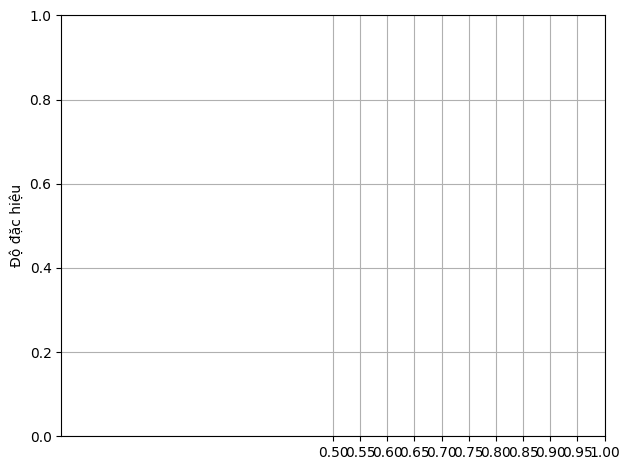

In [8]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Hàm tiền xử lý ảnh
def preprocess_images(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_width, img_height))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=-1)  # Thêm chiều cho ảnh
    return img

# Hàm tìm nhãn tốt nhất cho từng ảnh
def verify_fingerprint(fingerprint_image_path, model, features, labels):
    # Tiền xử lý ảnh đầu vào
    input_image = preprocess_images(fingerprint_image_path)
    input_image = np.expand_dims(input_image, axis=0)

    # Trích xuất đặc trưng
    input_feature = model.predict(input_image).flatten()

    # Tính toán độ tương đồng cosine
    similarities = cosine_similarity([input_feature], features)

    # Tìm đặc trưng có độ tương đồng cao nhất
    best_match_index = np.argmax(similarities)
    best_match_label = labels[best_match_index]

    return best_match_label, similarities[0][best_match_index]

# Hàm tải và xử lý các ảnh chưa được huấn luyện
def load_untrained_images(imgnotrain_path, model, features, labels):
    similarities = []
    best_labels = []
    
    for file in os.listdir(imgnotrain_path):
        if file.endswith(".BMP"):  # Kiểm tra định dạng tệp tin
            img_path = os.path.join(imgnotrain_path, file)
            best_label, similarity = verify_fingerprint(img_path, model, features, labels)
            
            similarities.append(similarity)
            best_labels.append(best_label)

    return similarities, best_labels

def calculate_metrics(similarities, best_labels, actual_labels, thresholds):
    metrics = {
        "threshold": [],
        "accuracy": [],
        "sensitivity": [],
        "specificity": []
    }

    for threshold in thresholds:
        tp = fp = tn = fn = 0
        
        for i in range(len(similarities)):
            if similarities[i] >= threshold:
                if best_labels[i] == actual_labels[i]:  # True Positive
                    tp += 1
                else:  # False Positive
                    fp += 1
            else:
                if best_labels[i] == actual_labels[i]:  # False Negative
                    fn += 1
                else:  # True Negative
                    tn += 1

        # Tính toán các chỉ số
        accuracy = (tp + tn) / len(similarities)
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Độ nhạy
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Độ đặc hiệu

        metrics["threshold"].append(threshold)
        metrics["accuracy"].append(accuracy)
        metrics["sensitivity"].append(sensitivity)
        metrics["specificity"].append(specificity)

    return metrics

def find_effective_thresholds(similarities, best_labels, actual_labels):
    thresholds = np.arange(0.9, 1.01, 0.01)  # Ngưỡng từ 0.5 đến 1 với bước nhảy 0.05
    metrics = calculate_metrics(similarities, best_labels, actual_labels, thresholds)
    
    return metrics

# Đường dẫn tới folder imgnotrain
imgnotrain_path = "Data\\SOCOFing\\Test1\\imgnotrain"  # Cập nhật đường dẫn tới folder imgnotrain
features = np.load('fingerprint_features.npy')  # Tải đặc trưng đã lưu
labels = np.load('fingerprint_labels.npy')  # Tải nhãn đã lưu

# Tạo danh sách nhãn thực tế từ tên tệp (giả sử tên tệp có định dạng "0__image1.BMP")
actual_labels = []
for file in os.listdir(imgnotrain_path):
    if file.endswith(".BMP"):
        label = int(file.split("__")[0]) - 1  # Lấy nhãn từ tên tệp
        actual_labels.append(label)

# Tải và xử lý các hình ảnh chưa được huấn luyện
similarities, best_labels = load_untrained_images(imgnotrain_path, model, features, labels)
if len(similarities) != len(best_labels) or len(best_labels) != len(actual_labels):
    print("Lỗi: Các danh sách không có cùng chiều dài.")
else:
    # Tìm ngưỡng hiệu quả
    metrics = find_effective_thresholds(similarities, best_labels, actual_labels)

    # Vẽ biểu đồ cho các chỉ số
    plt.ylabel('Độ đặc hiệu')
    plt.xticks(np.arange(0.5, 1.05, 0.05))
    plt.grid()

    plt.tight_layout()  # Đảm bảo không có chồng chéo giữa các biểu đồ
    plt.show()

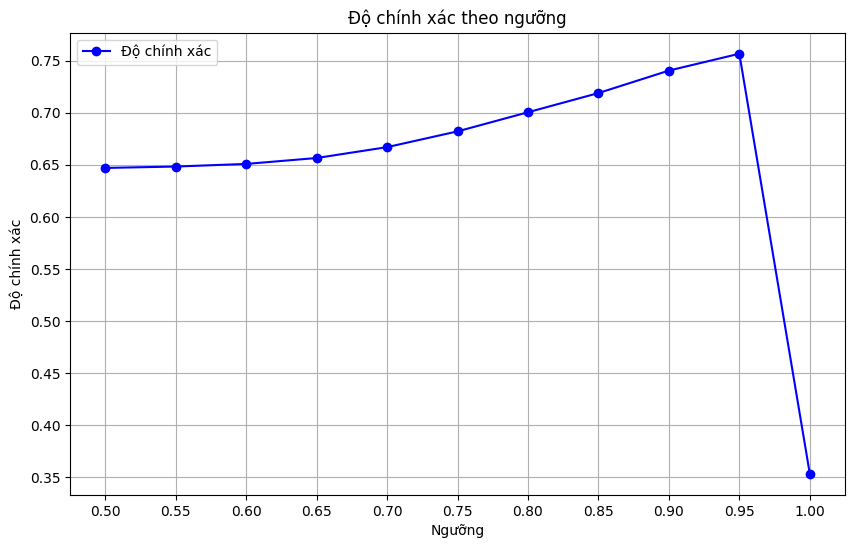

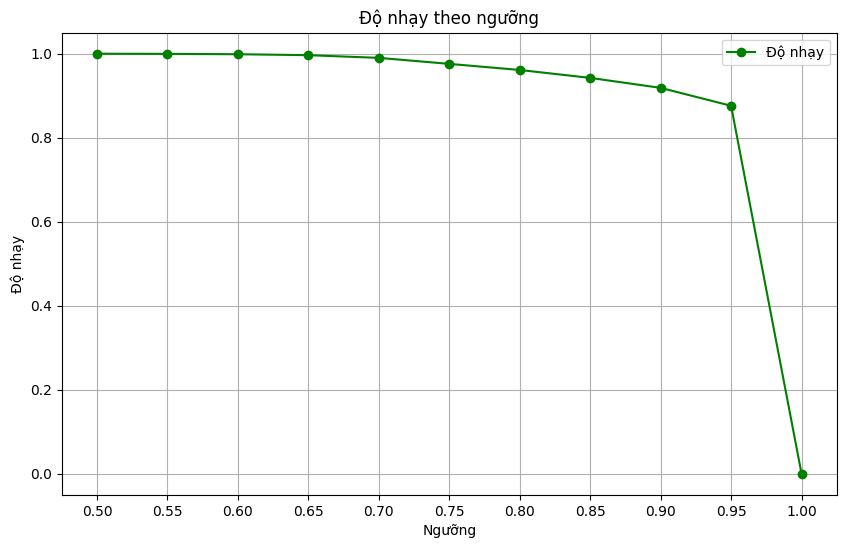

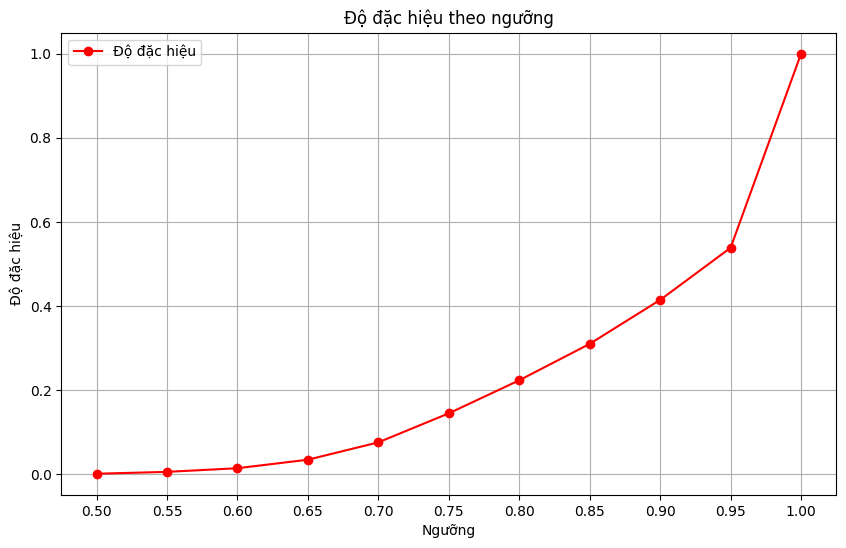

In [7]:
thresholds = metrics["threshold"]
plt.figure(figsize=(10, 6))
plt.plot(thresholds, metrics["accuracy"], marker='o', label='Độ chính xác', color='blue')
plt.title('Độ chính xác theo ngưỡng')
plt.xlabel('Ngưỡng')
plt.ylabel('Độ chính xác')
plt.xticks(np.arange(0.5, 1.05, 0.05))
plt.grid()
plt.legend()
plt.show()

# Biểu đồ cho Độ nhạy
plt.figure(figsize=(10, 6))
plt.plot(thresholds, metrics["sensitivity"], marker='o', label='Độ nhạy', color='green')
plt.title('Độ nhạy theo ngưỡng')
plt.xlabel('Ngưỡng')
plt.ylabel('Độ nhạy')
plt.xticks(np.arange(0.5, 1.05, 0.05))
plt.grid()
plt.legend()
plt.show()

# Biểu đồ cho Độ đặc hiệu
plt.figure(figsize=(10, 6))
plt.plot(thresholds, metrics["specificity"], marker='o', label='Độ đặc hiệu', color='red')
plt.title('Độ đặc hiệu theo ngưỡng')
plt.xlabel('Ngưỡng')
plt.ylabel('Độ đặc hiệu')
plt.xticks(np.arange(0.5, 1.05, 0.05))
plt.grid()
plt.legend()
plt.show()

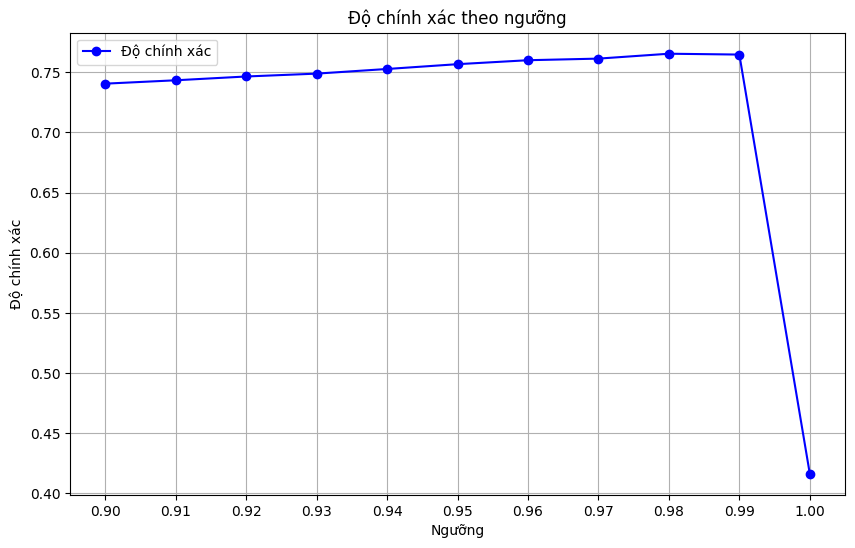

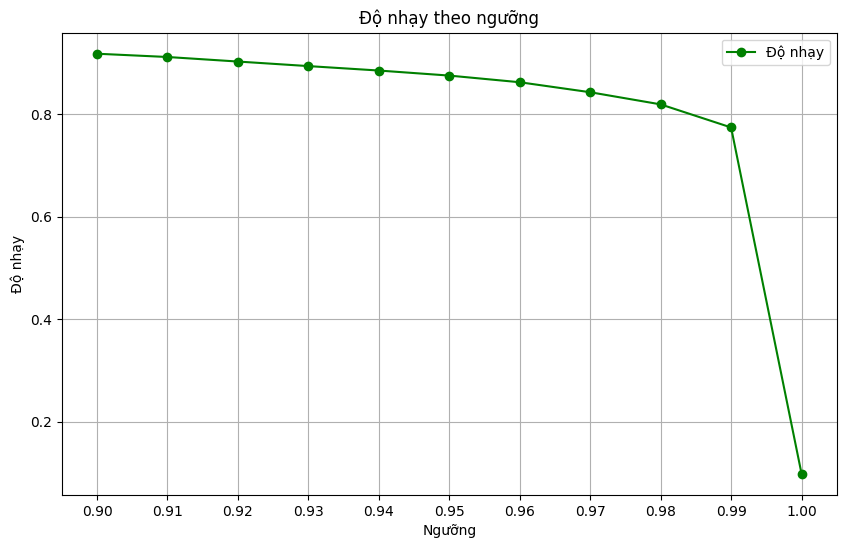

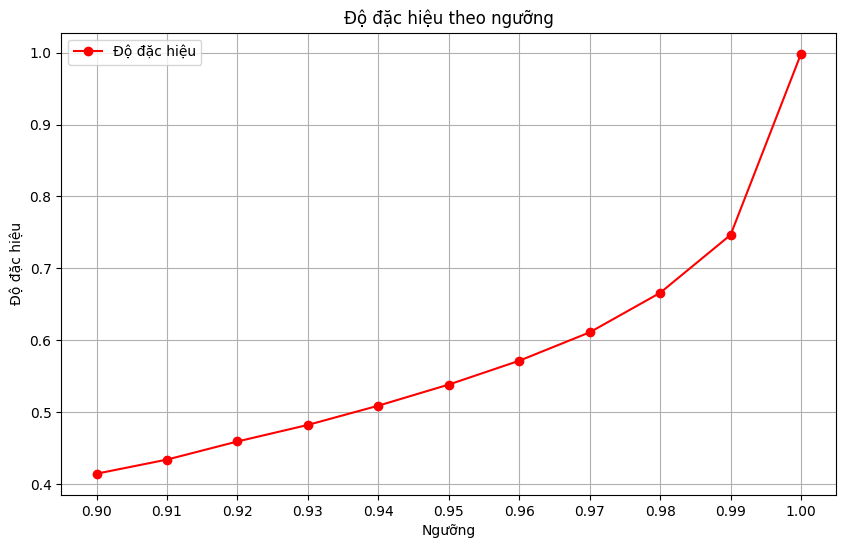

In [10]:
thresholds = metrics["threshold"]
plt.figure(figsize=(10, 6))
plt.plot(thresholds, metrics["accuracy"], marker='o', label='Độ chính xác', color='blue')
plt.title('Độ chính xác theo ngưỡng')
plt.xlabel('Ngưỡng')
plt.ylabel('Độ chính xác')
plt.xticks(np.arange(0.9, 1.01, 0.01))
plt.grid()
plt.legend()
plt.show()

# Biểu đồ cho Độ nhạy
plt.figure(figsize=(10, 6))
plt.plot(thresholds, metrics["sensitivity"], marker='o', label='Độ nhạy', color='green')
plt.title('Độ nhạy theo ngưỡng')
plt.xlabel('Ngưỡng')
plt.ylabel('Độ nhạy')
plt.xticks(np.arange(0.9, 1.01, 0.01))
plt.grid()
plt.legend()
plt.show()

# Biểu đồ cho Độ đặc hiệu
plt.figure(figsize=(10, 6))
plt.plot(thresholds, metrics["specificity"], marker='o', label='Độ đặc hiệu', color='red')
plt.title('Độ đặc hiệu theo ngưỡng')
plt.xlabel('Ngưỡng')
plt.ylabel('Độ đặc hiệu')
plt.xticks(np.arange(0.9, 1.01, 0.01))
plt.grid()
plt.legend()
plt.show()